### Load Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
import calendar
import os
import pprint
from elasticsearch import Elasticsearch

import dtale
%matplotlib inline
pd.set_option('display.max_columns', None)

### EDA 

In [2]:
path = 'C:\\Users\\bokhy\\Desktop\\ATG\\'
path = 'C:\\Users\\bokhy\\Desktop\\'

df = pd.read_csv(os.path.join(path, 'Production Arcade Logs.csv'), engine='python')

In [3]:
# Select preferred time zone to present timestamps
TIMEZONE = 'America/New_York'
TIMEZONE = 'America/Los_Angeles'
TIMEZONE = 'Asia/Taipei'
TIMEZONE = 'utc'

In [4]:
df['service'] = ['Built-in 350' if x<10000 else ('BYOG' if x< 10000000 else ('ArcadeNet' if x>= 10000000 else 'N/A')) for x in df['activity.game_id']]

In [5]:
df1 = df[df.log_type == 'game-play']
df2 = df[df.log_type == 'Game']

In [6]:
# Cabinets < 4.10.0
def Preprocess1(df):
    df['log.timestamp'] = pd.DatetimeIndex(pd.to_datetime(df['log.timestamp'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['activity.play_start'] = pd.DatetimeIndex(pd.to_datetime(df['activity.play_start'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['activity.play_end'] = pd.DatetimeIndex(pd.to_datetime(df['activity.play_end'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['playtime'] = df['activity.play_end'] - df['activity.play_start'] 
    df = df.rename(columns={"log.timestamp": "play_end"})
    df['play_start'] = df['play_end'] - df['playtime']
    df['weekday'] = df['play_start'].dt.day_name()
    df['year'] = df['play_start'].dt.year
    df['month'] = df['play_start'].dt.month
    df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])
    df['day'] = df['play_start'].dt.day
    df['hour'] = df['play_start'].dt.hour
    df['minute'] = df['play_start'].dt.minute
    df['second'] = df['play_start'].dt.second
    df['date'] = df["month"]+ "-" + df["day"].map(str)
    df = df.drop(['activity.play_start','activity.play_end','log_at'], axis=1)
    return df

# Cabinets >= 4.10.0
def Preprocess2(df):
    df['activity.play_start'] = pd.DatetimeIndex(pd.to_datetime(df['activity.play_start'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['activity.play_end'] = pd.DatetimeIndex(pd.to_datetime(df['activity.play_end'],format="%b %d, %Y @ %H:%M:%S.%f"),tz = TIMEZONE)
    df['playtime'] = df['activity.play_end'] - df['activity.play_start'] 
    df = df.rename(columns={"activity.play_start": "play_start","activity.play_end": "play_end"})
    df['weekday'] = df['play_start'].dt.day_name()
    df['year'] = df['play_start'].dt.year
    df['month'] = df['play_start'].dt.month
    df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])
    df['day'] = df['play_start'].dt.day
    df['hour'] = df['play_start'].dt.hour
    df['minute'] = df['play_start'].dt.minute
    df['second'] = df['play_start'].dt.second
    df['date'] = df["month"]+ "-" + df["day"].map(str)
    df = df.drop(['log.timestamp','log_at'], axis=1)
    return df

In [7]:
def Numericalize(df):
    cols = ['activity.play_duration','activity.1p_buttons','activity.1p_joystick','activity.1p_spinner',
           'activity.2p_buttons','activity.2p_spinner','activity.2p_joystick'] 
    for i in cols:
        df[i] = df[i].str.replace(",","").astype(float)
        df[i] = df[i].apply(pd.to_numeric)
    return df

In [8]:
df1 = Preprocess1(df1)
df2 = Preprocess2(df2)

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [9]:
df = df1.append(df2)
df = df.sort_values("play_start",ascending=False)
df = Numericalize(df)

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:7138: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [10]:
df = df.astype({'activity.play_duration': 'int64'})
df['activity.play_duration'] = df['activity.play_duration'] / 3600

In [11]:
df.head()

,@timestamp,account.created_date,account.current_sign_in_at,account.current_sign_in_ip,account.email,account.uuid,activity.1p_buttons,activity.1p_joystick,activity.1p_spinner,activity.2p_buttons,activity.2p_joystick,activity.2p_spinner,activity.attract_idle_time,activity.display_firmware,activity.game_id,activity.game_title,activity.play_duration,date,day,geoip.city_name,geoip.continent_name,geoip.country_iso_code,geoip.location.lat,geoip.location.lon,geoip.region_name,geoip.timezone,hour,log_type,machine_type,machine_uuid,minute,month,play_end,play_start,playtime,remote_ip,second,service,tags,weekday,year
535,"Apr 13, 2020 @ 22:52:25.101","Mar 25, 2020 @ 22:05:22.000","Apr 13, 2020 @ 22:52:21.000",107.194.137.171,rnt3rd.gaming@gmail.com,2aee9abf-674c-42d9-95c6-8aabc0919258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.14.0,5411,DESKTOP-4EJFHKP,0.001667,Apr-13,13,Grand Prairie,North America,US,32.767,-97.007,Texas,America/Chicago,22,Game,Ultimate Legend,88001912B0019358,47,Apr,2020-04-13 22:48:03+00:00,2020-04-13 22:47:57+00:00,00:00:06,107.194.137.171,57,Built-in 350,"[""ArcadeNet-Live""]",Monday,2020
227,"Apr 13, 2020 @ 23:25:59.482","Mar 25, 2020 @ 22:05:22.000","Apr 13, 2020 @ 22:52:21.000",107.194.137.171,rnt3rd.gaming@gmail.com,2aee9abf-674c-42d9-95c6-8aabc0919258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.14.0,5411,DESKTOP-4EJFHKP,0.001667,Apr-13,13,Grand Prairie,North America,US,32.767,-97.007,Texas,America/Chicago,22,Game,Ultimate Legend,88001912B0019358,47,Apr,2020-04-13 22:48:03+00:00,2020-04-13 22:47:57+00:00,00:00:06,107.194.137.171,57,Built-in 350,"[""ArcadeNet-Live""]",Monday,2020
534,"Apr 13, 2020 @ 22:52:25.101","Mar 25, 2020 @ 22:05:22.000","Apr 13, 2020 @ 22:52:21.000",107.194.137.171,rnt3rd.gaming@gmail.com,2aee9abf-674c-42d9-95c6-8aabc0919258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.14.0,5411,DESKTOP-4EJFHKP,0.001944,Apr-13,13,Grand Prairie,North America,US,32.767,-97.007,Texas,America/Chicago,22,Game,Ultimate Legend,88001912B0019358,45,Apr,2020-04-13 22:45:16+00:00,2020-04-13 22:45:09+00:00,00:00:07,107.194.137.171,9,Built-in 350,"[""ArcadeNet-Live""]",Monday,2020
226,"Apr 13, 2020 @ 23:25:59.482","Mar 25, 2020 @ 22:05:22.000","Apr 13, 2020 @ 22:52:21.000",107.194.137.171,rnt3rd.gaming@gmail.com,2aee9abf-674c-42d9-95c6-8aabc0919258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.14.0,5411,DESKTOP-4EJFHKP,0.001944,Apr-13,13,Grand Prairie,North America,US,32.767,-97.007,Texas,America/Chicago,22,Game,Ultimate Legend,88001912B0019358,45,Apr,2020-04-13 22:45:16+00:00,2020-04-13 22:45:09+00:00,00:00:07,107.194.137.171,9,Built-in 350,"[""ArcadeNet-Live""]",Monday,2020
0,"Apr 13, 2020 @ 23:26:05.129","Mar 31, 2020 @ 22:41:05.000","Apr 13, 2020 @ 22:49:42.000",68.74.201.51,dimas_sb@yahoo.com,5f86e579-0f8c-477d-a26b-b06e08345fb2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.14.0,5009901,Cloud BYOG™,0.330000,Apr-13,13,Houston,North America,US,29.774,-95.406,Texas,America/Chicago,22,Game,Ultimate Legend,88001912B01102C0,21,Apr,2020-04-13 22:41:21+00:00,2020-04-13 22:21:33+00:00,00:19:48,68.74.201.51,33,BYOG,"[""ArcadeNet-Live""]",Monday,2020


In [12]:
df.shape

(4851, 41)

In [13]:
df.to_csv("aba.csv", index=False)

### Simple Plots

In [44]:
df_new = df.groupby('activity.game_title').agg({'playtime': 'sum','activity.1p_buttons': 'sum','activity.1p_joystick': 'sum','activity.1p_spinner': 'sum',
                                               'activity.2p_buttons': 'sum','activity.2p_joystick': 'sum','activity.2p_spinner': 'sum'}).sort_values('playtime', ascending=False).rename(columns={'playtime': 'Playtime(Hours)'})
df_new = df_new.reset_index().sort_values('Playtime(Hours)', ascending=False)

In [45]:
df_new.round(2)

,activity.game_title,Playtime(Hours),activity.1p_buttons,activity.1p_joystick,activity.1p_spinner,activity.2p_buttons,activity.2p_joystick,activity.2p_spinner
0,Missile Command® (Arcade),21:03:47.360000,6140.0,183.0,428550.0,6.0,0.0,362970.0
1,BurgerTime™ (Arcade),12:06:59.934000,520.0,7099.0,3197.0,6.0,166.0,1193.0
2,Cloud BYOG™,09:44:51,0.0,0.0,0.0,0.0,0.0,0.0
3,Cloud BYOG,07:37:22.933000,0.0,0.0,0.0,0.0,0.0,0.0
4,Steam,05:55:40.033000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
303,Basketball (2600),00:00:24,19.0,16.0,0.0,0.0,0.0,0.0
304,Tempest® (2600),00:00:24,31.0,18.0,206.0,0.0,0.0,176.0
305,Asteroids® (2600),00:00:20.105000,39.0,5.0,0.0,0.0,0.0,0.0
306,Realsports® Football (2600),00:00:19,6.0,3.0,17.0,0.0,0.0,10.0


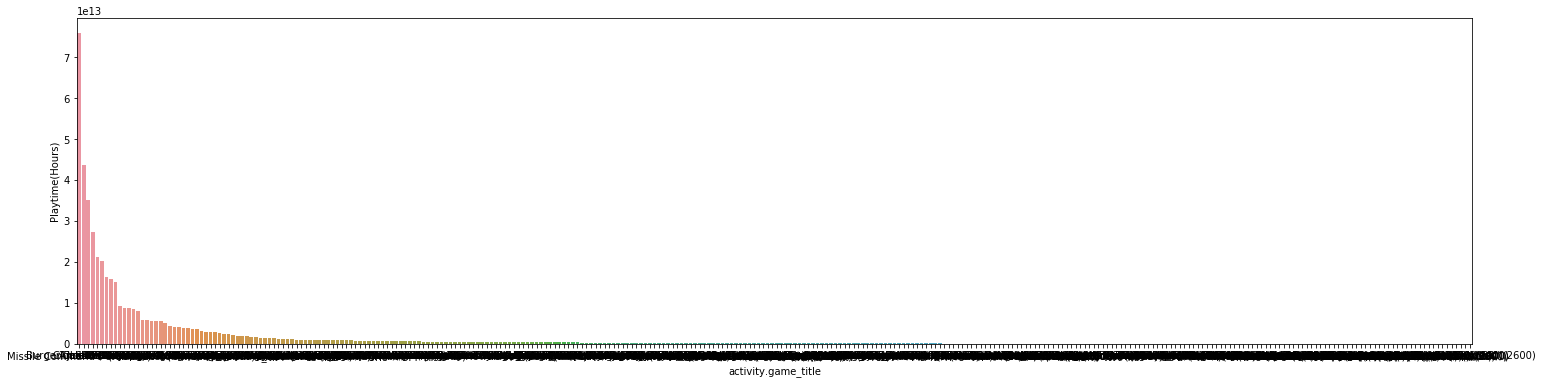

Executing shutdown due to inactivity...


2020-03-23 18:28:53,633 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2020-03-23 18:29:09,694 - INFO     - Executing shutdown...


In [46]:
f, ax = plt.subplots(figsize=(25, 6))
sns.barplot(x='activity.game_title', y='Playtime(Hours)' , data=df_new)

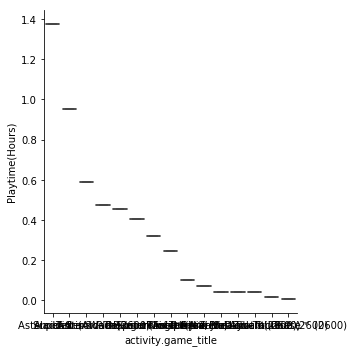

In [275]:
sns.catplot(x="activity.game_title", y="Playtime(Hours)",
                data=df_new, kind="box")

In [ ]:
sns.catplot(x="hour", y="Weekdays",
                hue="machine_uuid", col="service",
                data=df, kind="box")

In [ ]:
sns.catplot(x="Weekdays",
                hue="service", col="service",col_wrap=4,
                data=df, kind="count")